In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/train_data_new.zip')
zip_file.extractall('/content/')

In [ ]:
import torch
import numpy as np
import random

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(33)

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
set_seed(33)
train_transform = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ], p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=7, p=0.5),
        A.MedianBlur(blur_limit=7, p=0.5)
    ], p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

class BalancedDataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.breeds = os.listdir(root_dir)
        self.all_images = [] 

    def prepare_all_data(self):
        self.all_images = []  

        for breed in self.breeds:
            happy_dir = os.path.join(self.root_dir, breed, 'happy')
            not_happy_dir = os.path.join(self.root_dir, breed, 'not_happy')

            happy_images = [os.path.join(happy_dir, img) for img in os.listdir(happy_dir)]
            not_happy_images = [os.path.join(not_happy_dir, img) for img in os.listdir(not_happy_dir)]

            self.all_images.extend([(img, 0) for img in happy_images])
            self.all_images.extend([(img, 1) for img in not_happy_images])

        # 이미지 경로와 레이블 분리
        self.img_paths, self.labels = zip(*self.all_images) 

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)  
            return image, label
        else:
            return image

### dataset, dataloader 구축

In [6]:
train_dir = '/content/train_data_new'

balanced_dataset = BalancedDataset(train_dir)
balanced_dataset.prepare_all_data()

img_paths = balanced_dataset.img_paths
labels = balanced_dataset.labels
train_img_paths, val_img_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, random_state=33, stratify=labels
)
print(len(img_paths),len(labels))

train_dataset = CustomDataset(train_img_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_img_paths, val_labels, transform=test_transform)

generator = torch.Generator().manual_seed(33)

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, generator=generator
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print("Train Labels Distribution:")
print(train_label_counts)

print("\nValidation Labels Distribution:")
print(val_label_counts)

11028 11028
Train Labels Distribution:
Counter({1: 4934, 0: 3888})

Validation Labels Distribution:
Counter({1: 1234, 0: 972})


### train(), validate() 정의

In [ ]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader,scheduler=None):
    model.train()
    running_loss = 0.0
    corrects = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if scheduler!=None:
          scheduler.step()

        preds = torch.sigmoid(outputs) > 0.5 
        corrects += torch.sum(preds == labels.byte())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5  
            val_corrects += torch.sum(preds == labels.byte())

    epoch_loss = val_loss / len(val_loader)
    epoch_acc = val_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
def save_checkpoint(epoch, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,  
        'val_losses': val_losses,      
        'train_accuracies': train_accuracies,  
        'val_accuracies': val_accuracies      
    }
    torch.save(checkpoint, save_path)

### efficientnet- adamw, ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 
100%|██████████| 138/138 [00:08<00:00, 17.24it/s]


Epoch 1/50, Train Loss: 0.3556, Train Accuracy: 0.8501, Validation Loss: 0.2038, Validation Accuracy: 0.9234


100%|██████████| 138/138 [00:07<00:00, 19.07it/s]


Epoch 2/50, Train Loss: 0.2762, Train Accuracy: 0.8957, Validation Loss: 0.2158, Validation Accuracy: 0.9198


100%|██████████| 138/138 [00:07<00:00, 17.58it/s]


Epoch 3/50, Train Loss: 0.2395, Train Accuracy: 0.9103, Validation Loss: 0.1996, Validation Accuracy: 0.9261


100%|██████████| 138/138 [00:07<00:00, 19.59it/s]


Epoch 4/50, Train Loss: 0.2263, Train Accuracy: 0.9137, Validation Loss: 0.1895, Validation Accuracy: 0.9306


100%|██████████| 138/138 [00:07<00:00, 17.38it/s]


Epoch 5/50, Train Loss: 0.2110, Train Accuracy: 0.9196, Validation Loss: 0.2057, Validation Accuracy: 0.9248


100%|██████████| 138/138 [00:06<00:00, 19.88it/s]


Epoch 6/50, Train Loss: 0.2017, Train Accuracy: 0.9230, Validation Loss: 0.1756, Validation Accuracy: 0.9311


100%|██████████| 138/138 [00:07<00:00, 17.47it/s]


Epoch 7/50, Train Loss: 0.1802, Train Accuracy: 0.9316, Validation Loss: 0.2444, Validation Accuracy: 0.9080


100%|██████████| 138/138 [00:06<00:00, 19.78it/s]


Epoch 8/50, Train Loss: 0.1847, Train Accuracy: 0.9293, Validation Loss: 0.1993, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:07<00:00, 17.68it/s]


Epoch 9/50, Train Loss: 0.1612, Train Accuracy: 0.9379, Validation Loss: 0.2197, Validation Accuracy: 0.9225


100%|██████████| 138/138 [00:07<00:00, 18.89it/s]


Epoch 10/50, Train Loss: 0.1236, Train Accuracy: 0.9560, Validation Loss: 0.2033, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:07<00:00, 18.32it/s]


Epoch 11/50, Train Loss: 0.1077, Train Accuracy: 0.9624, Validation Loss: 0.1916, Validation Accuracy: 0.9352
Early stopping triggered.


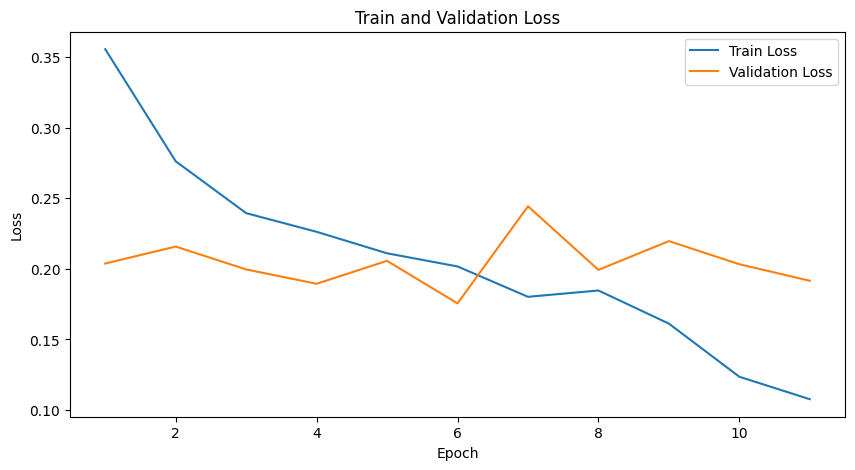

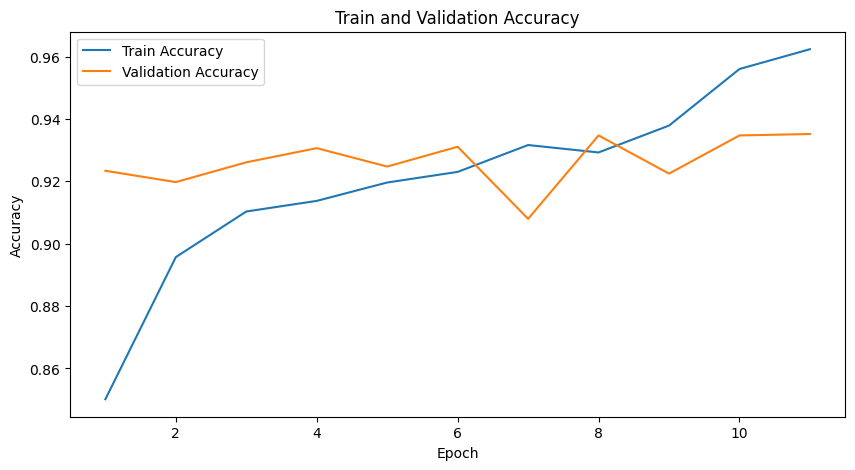

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

set_seed(33)
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[5:].parameters():  
    param.requires_grad = True
num_classes = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        save_path = f"/content/eff_ada_re_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [10]:
save_path = f"/content/eff_ada_re_b.pth"
save_checkpoint(11, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### efficientnet - AdamW

100%|██████████| 138/138 [00:07<00:00, 18.25it/s]


Epoch 1/50, Train Loss: 0.3497, Train Accuracy: 0.8590, Validation Loss: 0.2392, Validation Accuracy: 0.9202


100%|██████████| 138/138 [00:07<00:00, 18.00it/s]


Epoch 2/50, Train Loss: 0.2752, Train Accuracy: 0.8938, Validation Loss: 0.1973, Validation Accuracy: 0.9316


100%|██████████| 138/138 [00:07<00:00, 19.32it/s]


Epoch 3/50, Train Loss: 0.2411, Train Accuracy: 0.9046, Validation Loss: 0.1917, Validation Accuracy: 0.9311


100%|██████████| 138/138 [00:08<00:00, 17.16it/s]


Epoch 4/50, Train Loss: 0.2236, Train Accuracy: 0.9140, Validation Loss: 0.1949, Validation Accuracy: 0.9311


100%|██████████| 138/138 [00:07<00:00, 19.62it/s]


Epoch 5/50, Train Loss: 0.2018, Train Accuracy: 0.9255, Validation Loss: 0.1793, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:07<00:00, 17.76it/s]


Epoch 6/50, Train Loss: 0.1902, Train Accuracy: 0.9253, Validation Loss: 0.1898, Validation Accuracy: 0.9316


100%|██████████| 138/138 [00:07<00:00, 19.22it/s]


Epoch 7/50, Train Loss: 0.1853, Train Accuracy: 0.9318, Validation Loss: 0.2048, Validation Accuracy: 0.9216


100%|██████████| 138/138 [00:08<00:00, 17.22it/s]


Epoch 8/50, Train Loss: 0.1691, Train Accuracy: 0.9401, Validation Loss: 0.2071, Validation Accuracy: 0.9143


100%|██████████| 138/138 [00:07<00:00, 19.07it/s]


Epoch 9/50, Train Loss: 0.1621, Train Accuracy: 0.9397, Validation Loss: 0.1906, Validation Accuracy: 0.9352


100%|██████████| 138/138 [00:07<00:00, 17.60it/s]


Epoch 10/50, Train Loss: 0.1532, Train Accuracy: 0.9430, Validation Loss: 0.2129, Validation Accuracy: 0.9198
Early stopping triggered.


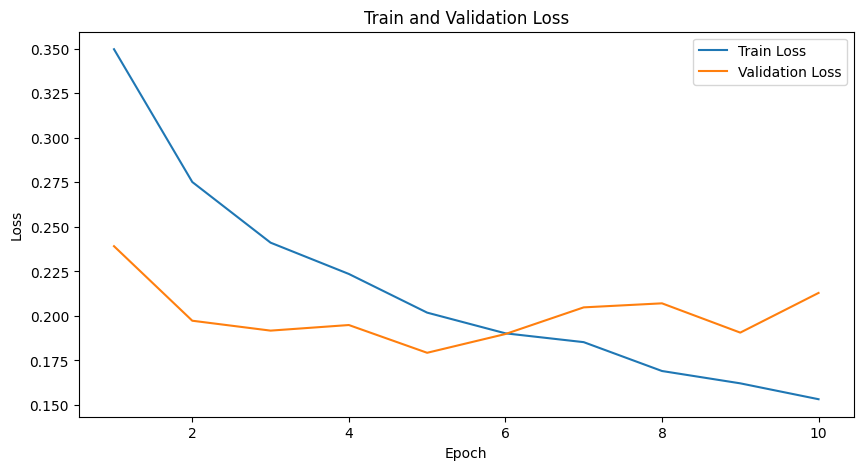

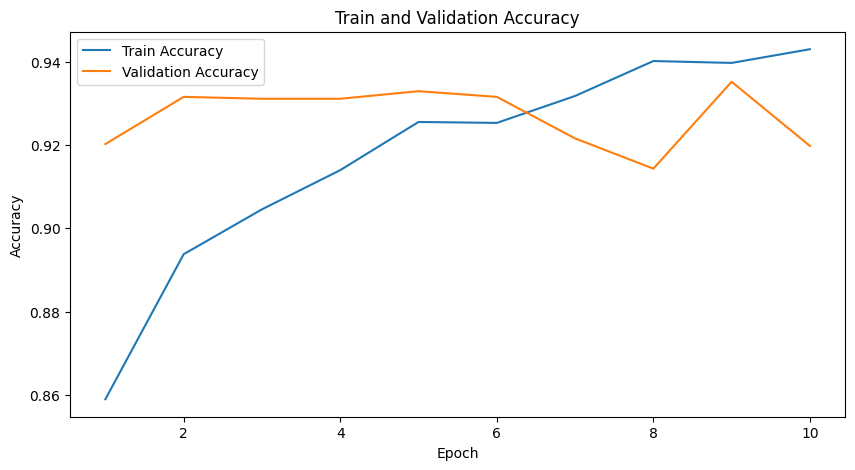

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

set_seed(33)
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[5:].parameters():  
    param.requires_grad = True

num_classes = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf') 
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/eff_ada_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [13]:
save_path = f"/content/eff_ada_b.pth"
save_checkpoint(10, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### efficientnet - sgd, CosineAnnealingLR

100%|██████████| 138/138 [00:07<00:00, 17.69it/s]


Epoch 1/50, Train Loss: 0.3725, Train Accuracy: 0.8330, Validation Loss: 0.2214, Validation Accuracy: 0.9229


100%|██████████| 138/138 [00:07<00:00, 18.35it/s]


Epoch 2/50, Train Loss: 0.2641, Train Accuracy: 0.8958, Validation Loss: 0.1893, Validation Accuracy: 0.9302


100%|██████████| 138/138 [00:07<00:00, 17.29it/s]


Epoch 3/50, Train Loss: 0.2206, Train Accuracy: 0.9114, Validation Loss: 0.1795, Validation Accuracy: 0.9393


100%|██████████| 138/138 [00:07<00:00, 18.59it/s]


Epoch 4/50, Train Loss: 0.2001, Train Accuracy: 0.9207, Validation Loss: 0.1838, Validation Accuracy: 0.9374


100%|██████████| 138/138 [00:07<00:00, 17.30it/s]


Epoch 5/50, Train Loss: 0.1821, Train Accuracy: 0.9318, Validation Loss: 0.1731, Validation Accuracy: 0.9411


100%|██████████| 138/138 [00:07<00:00, 19.05it/s]


Epoch 6/50, Train Loss: 0.1574, Train Accuracy: 0.9418, Validation Loss: 0.1917, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:07<00:00, 17.36it/s]


Epoch 7/50, Train Loss: 0.1487, Train Accuracy: 0.9442, Validation Loss: 0.1886, Validation Accuracy: 0.9361


100%|██████████| 138/138 [00:07<00:00, 19.56it/s]


Epoch 8/50, Train Loss: 0.1368, Train Accuracy: 0.9500, Validation Loss: 0.2037, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:08<00:00, 17.19it/s]


Epoch 9/50, Train Loss: 0.1427, Train Accuracy: 0.9496, Validation Loss: 0.1864, Validation Accuracy: 0.9365


100%|██████████| 138/138 [00:07<00:00, 18.33it/s]


Epoch 10/50, Train Loss: 0.1449, Train Accuracy: 0.9481, Validation Loss: 0.1771, Validation Accuracy: 0.9415
Early stopping triggered.


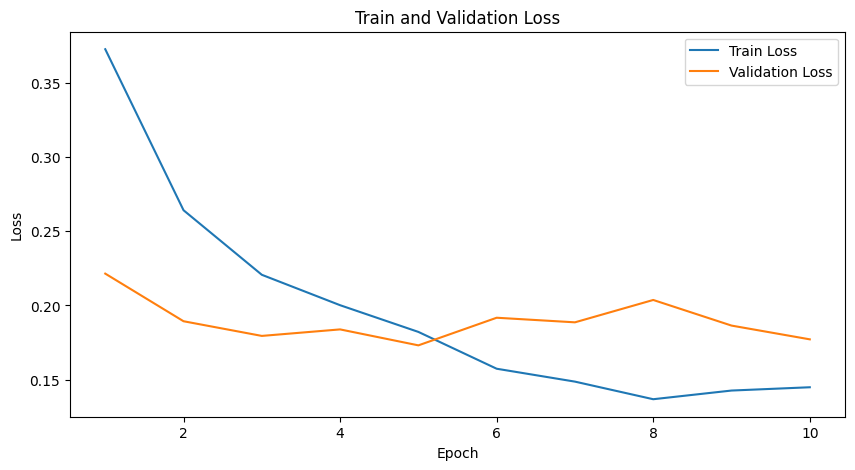

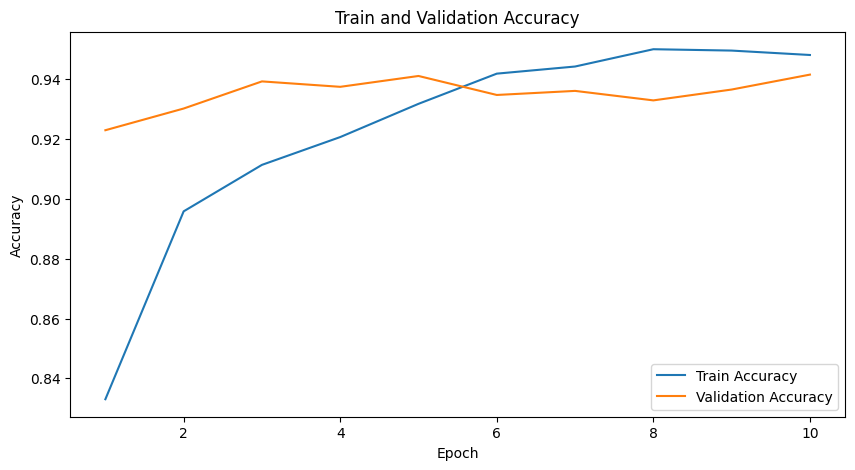

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

set_seed(33)
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[5:].parameters(): 
    param.requires_grad = True

num_classes = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),  
    lr=0.01,  
    momentum=0.9,  
    weight_decay=1e-3  
)

scheduler = CosineAnnealingLR(optimizer, T_max=25)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5  
best_val_loss = float('inf') 
early_stop_counter = 0 

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader,scheduler)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/eff_sgd_cos_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1  

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
save_path = f"/content/eff_sgd_cos_b.pth"
save_checkpoint(10, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)

### efficientnetb0 - sgd

100%|██████████| 138/138 [00:07<00:00, 19.66it/s]


Epoch 1/50, Train Loss: 0.3477, Train Accuracy: 0.8473, Validation Loss: 0.2011, Validation Accuracy: 0.9220


100%|██████████| 138/138 [00:07<00:00, 17.94it/s]


Epoch 2/50, Train Loss: 0.2452, Train Accuracy: 0.9049, Validation Loss: 0.1867, Validation Accuracy: 0.9311


100%|██████████| 138/138 [00:08<00:00, 15.51it/s]


Epoch 3/50, Train Loss: 0.2135, Train Accuracy: 0.9163, Validation Loss: 0.1850, Validation Accuracy: 0.9338


100%|██████████| 138/138 [00:07<00:00, 18.74it/s]


Epoch 4/50, Train Loss: 0.1797, Train Accuracy: 0.9295, Validation Loss: 0.1998, Validation Accuracy: 0.9329


100%|██████████| 138/138 [00:07<00:00, 17.90it/s]


Epoch 5/50, Train Loss: 0.1720, Train Accuracy: 0.9363, Validation Loss: 0.2297, Validation Accuracy: 0.9225


100%|██████████| 138/138 [00:07<00:00, 19.70it/s]


Epoch 6/50, Train Loss: 0.1700, Train Accuracy: 0.9344, Validation Loss: 0.1884, Validation Accuracy: 0.9347


100%|██████████| 138/138 [00:07<00:00, 17.93it/s]


Epoch 7/50, Train Loss: 0.1677, Train Accuracy: 0.9360, Validation Loss: 0.2019, Validation Accuracy: 0.9306


100%|██████████| 138/138 [00:07<00:00, 18.23it/s]


Epoch 8/50, Train Loss: 0.1602, Train Accuracy: 0.9396, Validation Loss: 0.1781, Validation Accuracy: 0.9374


100%|██████████| 138/138 [00:07<00:00, 19.44it/s]


Epoch 9/50, Train Loss: 0.1608, Train Accuracy: 0.9375, Validation Loss: 0.2403, Validation Accuracy: 0.9216


100%|██████████| 138/138 [00:08<00:00, 17.17it/s]


Epoch 10/50, Train Loss: 0.1634, Train Accuracy: 0.9354, Validation Loss: 0.2482, Validation Accuracy: 0.9143


100%|██████████| 138/138 [00:07<00:00, 19.42it/s]


Epoch 11/50, Train Loss: 0.1561, Train Accuracy: 0.9439, Validation Loss: 0.1859, Validation Accuracy: 0.9297


100%|██████████| 138/138 [00:07<00:00, 17.65it/s]


Epoch 12/50, Train Loss: 0.1717, Train Accuracy: 0.9365, Validation Loss: 0.2116, Validation Accuracy: 0.9270


100%|██████████| 138/138 [00:07<00:00, 19.17it/s]


Epoch 13/50, Train Loss: 0.1708, Train Accuracy: 0.9326, Validation Loss: 0.1984, Validation Accuracy: 0.9266
Early stopping triggered.


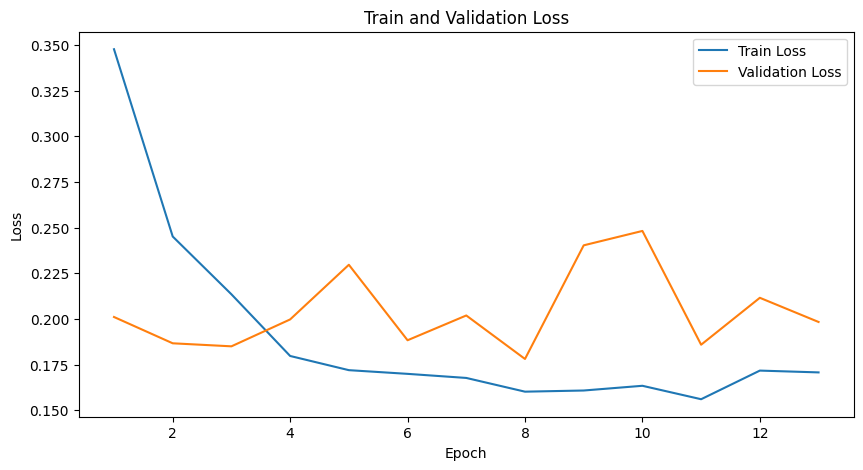

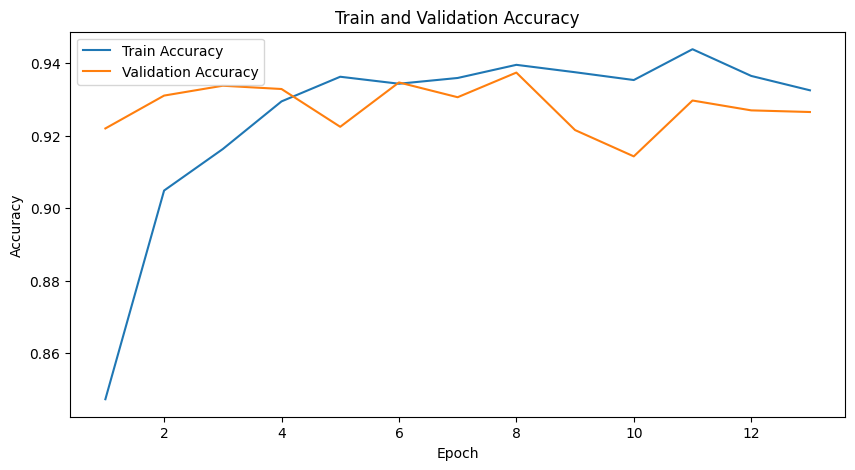

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

set_seed(33)
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[5:].parameters(): 
    param.requires_grad = True

num_classes = 1
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.01,  
    momentum=0.9,  
    weight_decay=1e-3  
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50
early_stop_patience = 5 
best_val_loss = float('inf')
early_stop_counter = 0  

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  
        save_path = f"/content/eff_sgd_b_epoch_{epoch+1}.pth"
        save_checkpoint(epoch+1, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# train, valid loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# train, valid accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
save_path = f"/content/eff_sgd_b.pth"
save_checkpoint(13, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies)